<a href="https://colab.research.google.com/github/seoho0529/TensorFlow/blob/main/tf19transfer_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 이미지 분류기를 직접 작성할 수도 있으나 이미 전문적으로 작성된 모델을 불러, 일부 영역의 학습을 통해
# 작성자가 원하는 모델을 만들 수 있다.
# 전이학습을 하면 방대한 데이터, 우수한 성능의 시스템이 없어도 나만의 우수 모델 사용이 가능
# 방법 1 : 특성 추출 기법 : 사전 훈련된 모델의 마지막 완전 연결층 부분만 새로 학습
# 방법 2 : 미세조정기법
# 베이스 모델은 MoblieNet v2

# %!pip install tensorflow-datasets

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteZ46964/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_

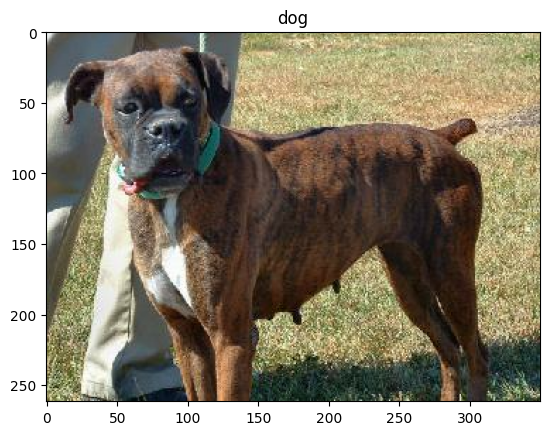

1
dog


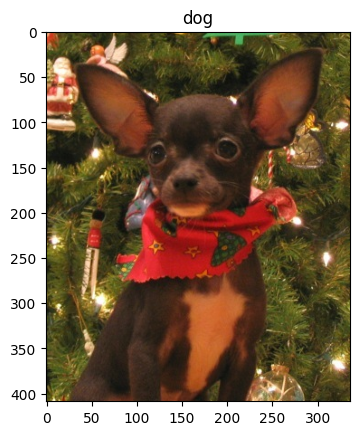

1
dog


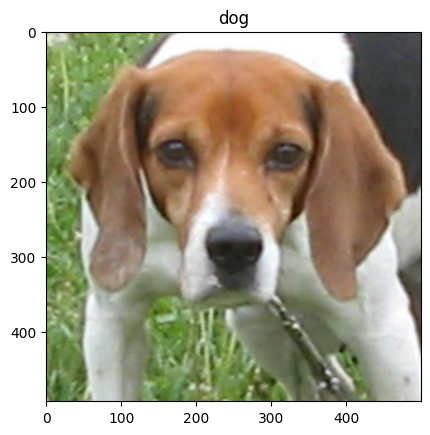

0
cat


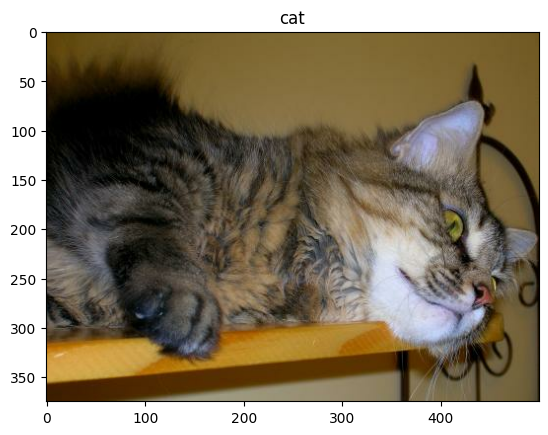

1
dog


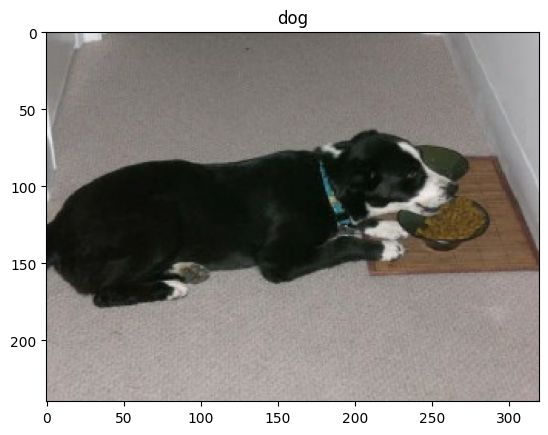

1
dog


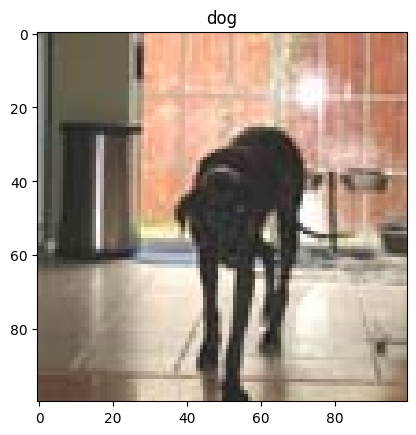

0
cat


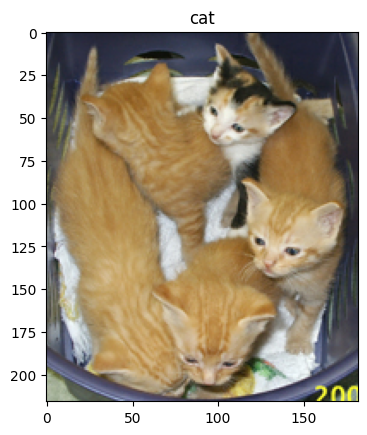

0
cat


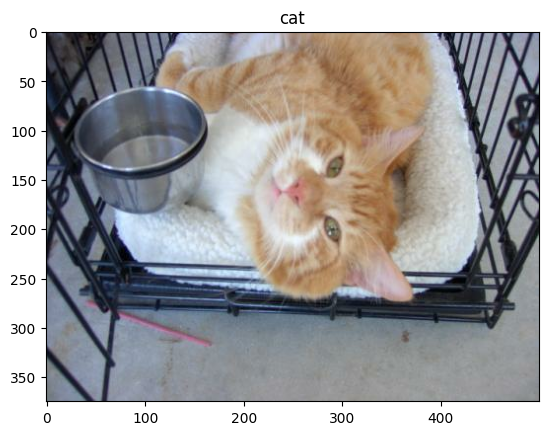

1
dog


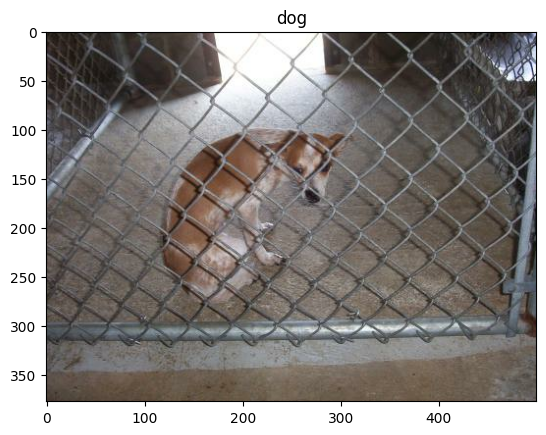

1
dog


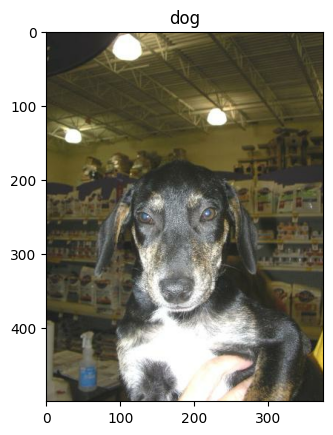

In [ ]:
(raw_train, raw_validation, raw_test), metadata =  tfds.load('cats_vs_dogs', split=['train[:80%]','train[80%:90%]','train[90%:]'], with_info=True, as_supervised=True)  # as_supervised : 튜플형식으로 가져오란 뜻, 8:1:1
print(raw_train)
print(raw_train.take(1))
print(raw_validation)
print(raw_test)
print(metadata)

get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(10):
  plt.figure()
  plt.imshow(image)
  print(label.numpy())  # tf.Tensor(1, shape=(), dtype=int64)
  print(get_label_name(label)) # dog:1    cat:0

  plt.title(get_label_name(label))
  plt.show()

  # 현재 데이터는 용량이 매우 크기 때문에 ram에 모두 로딩이 불가하다.
  # 때문에 데이터 파이프라인을 이용하면 이미지를 일부만 적당히 연속해서 읽어 처리가 가능하다. (하나 읽고 처리하고 지우고, 다른거 다시 읽고 처리하고 지우고)


In [ ]:
# 이미지 포맷팅, 셔플링 처리 : MoblieNet v2가 원하기 때문.
import tensorflow as tf

IMG_SIZE = 160

def format_exam(image, label):
  image = tf.cast(image, tf.float32)  # 이미지 데이터를 실수화
  image = (image / 127.5) - 1  # 데이터를 -1 ~ 1 사이로 크기를 맞춰줌
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

train = raw_train.map(format_exam)
validation = raw_validation.map(format_exam)
test = raw_test.map(format_exam)

# 이미지 배치
BATCH_SIZE = 32
SHUFFLE_BRFFER_SIZE = 1000

train_batches = train.shuffle(buffer_size=SHUFFLE_BRFFER_SIZE).batch(BATCH_SIZE)
validation_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
  pass

print(image_batch.shape, ' ', label_batch.shape)  # (32, 160, 160, 3)   (32,)

(32, 160, 160, 3)   (32,)


In [ ]:
# base model 작성 : MobileNet v2 - 래량의 자료로 충분히 학습된 분류 모델
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# 1
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet') # include_top(완전연결층)은 포함x, imagenet으로 학습된 MobileNetV2
# 입력층 -> CNN층(특징 추출) -> 완전연결층
# include_top=False를 하면 입력층 -> CNN층(특징 추출) : 완전연결층이 빠지고 이 부분만? 쓰겠다는 것

feature_batch = base_model(image_batch)  # (32, 160, 160, 3) 형태의 이미지 특징을 반환
# print(feature_batch)  #  shape=(32, 5, 5, 1280), dtype=float32)

# 계층 동결
base_model.trainable=False  # MobileNetV2는 학습이 끝났으므로 우리가 만들 모델에서는 학습에 참여 x
# print(base_model.summary())
# 순전파에선 참여하지만 역전파에선 우리가 만든 새로운 모델쪽의 Dense는 w를 갱신하지만  기존의 cnn 알고리즘 쪽은 갱신되지 않음(건들지 않음)

# 모델링
# 2
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()  # AveragePooling2D 보다 급격하게 feature의 수를 줄임(Global을 사용함으로써)
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)  # (32, 5, 5, 1280) -> (32, 1280)  , 평균값을 사용하므로 5,5가 축소된 것

# 3
prediction_layer = tf.keras.layers.Dense(1)  # units=1
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)  # (32, 1) | 순전파를 하고 형태는 (32, 1)

model = tf.keras.Sequential([
    base_model,      # 특징 추출 베이스 모델  - 외부에서 만든거 사용
    global_average_layer,  # 풀링 레이어
    prediction_layer  # 완전연결층 - 학습해야 할거
])

9406464/9406464 [==============================] - 0s 0us/step
(32, 1280)
(32, 1)


In [ ]:
base_learning_rate = 0.0001

optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(model.summary())

# 현재 모델 성능 : fit() 전
validation_step = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_step)
print('loss0 : ', loss0)  # 0.7524303197860718
print('accuracy0 : ', accuracy0)  # 0.557812511920929

initial_epochs = 10
history = model.fit(train_batches, epochs=initial_epochs, validation_data=validation_batches)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
None
20/20 [==============================] - 4s 42ms/step - loss: 0.7715 - accuracy: 0.5578
loss0 :  0.7715131044387817
accuracy0 :  0.5578125119209

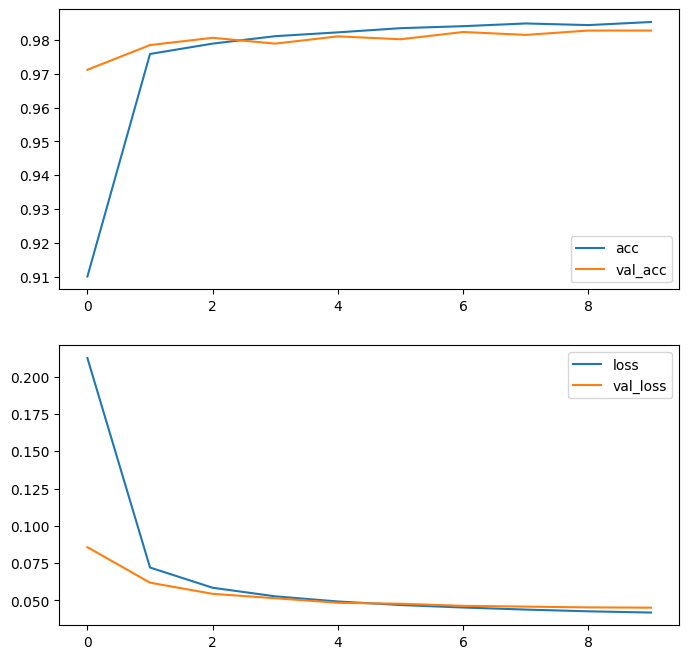

In [ ]:
# 학습 시 제공된 정보로 시각화
acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
loss = history.history['loss']
val_loss= history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='acc')
plt.plot(val_acc, label='val_acc')
plt.legend(loc='lower right')        # 정확도는 높지만 train이 급격해 보이므로 예측력은 조금 불안정하다. 그러므로 미세조정이 필요하다.(fine tuning)

plt.subplot(2,1,2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# 파인튜닝이란?
# 사전 학습된 인공지능 모델의 가중치를 새로운 데이터에 맞게 세밀하게 조정하여 성능을 향상시키고 학습 시간을 줄이는 과정이다.
# 전이학습이 끝난 모델에 대해 레이어 일부를 재조정하여 더 안정된 모델을 생산
# 베이스 모델의 끝단 레이어 일부도 학습에 참여

base_model.trainable = True # 베이스 모델의 학습동결을 해제
print('베이스 모델 레이어 수 : ', len(base_model.layers))   # 154
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable=False  # 베이스 모델의 앞단 100개는 학습동결을 함

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10), metrics=['accuracy'])   # learning_rate가 0.0001인데 10을 나눔으로써 0.00001이 됨 -> 미세조정
print(model.summary())

베이스 모델 레이어 수 :  154
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1862721 (7.11 MB)
Non-trainable params: 396544 (1.51 MB)
_________________________________________________________________
None


Epoch 10/15
582/582 [==============================] - 42s 64ms/step - loss: 0.0201 - accuracy: 0.9938 - val_loss: 0.0515 - val_accuracy: 0.9789
Epoch 11/15
582/582 [==============================] - 39s 66ms/step - loss: 0.0165 - accuracy: 0.9942 - val_loss: 0.0563 - val_accuracy: 0.9768
Epoch 12/15
582/582 [==============================] - 39s 65ms/step - loss: 0.0118 - accuracy: 0.9965 - val_loss: 0.0627 - val_accuracy: 0.9781
Epoch 13/15
582/582 [==============================] - 39s 65ms/step - loss: 0.0122 - accuracy: 0.9959 - val_loss: 0.0550 - val_accuracy: 0.9794
Epoch 14/15
582/582 [==============================] - 38s 64ms/step - loss: 0.0090 - accuracy: 0.9967 - val_loss: 0.0531 - val_accuracy: 0.9819
Epoch 15/15
582/582 [==============================] - 38s 62ms/step - loss: 0.0059 - accuracy: 0.9985 - val_loss: 0.0539 - val_accuracy: 0.9819


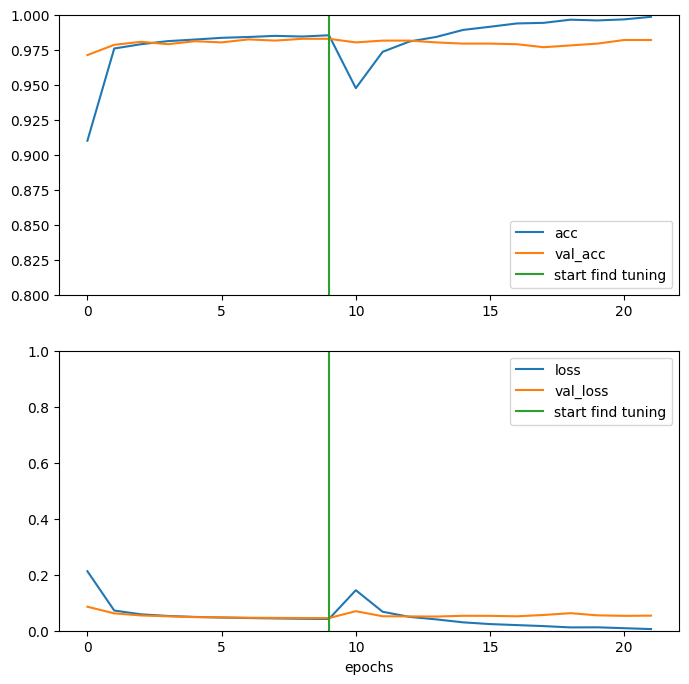

In [ ]:
# 파인튜닝 학습
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches, epochs=total_epochs,
                         initial_epoch = history.epoch[-1], validation_data=validation_batches)


# 시각화
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='acc')
plt.plot(val_acc, label='val_acc')
plt.ylim([0.8, 1])
plt.plot([initial_epochs - 1, initial_epochs -1], plt.ylim(), label='start find tuning')
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs - 1, initial_epochs -1], plt.ylim(), label='start find tuning')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.show()